In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.covariance import EllipticEnvelope
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
%matplotlib notebook

# Introduction
## The Dataset
In this notebook I explore the Openpowerlifting-Dataset from https://www.openpowerlifting.org/data.
The data consists of results from powerlifting meetings all over the world. Each row represents the performance of an athlete at a particular meeting. The columns 'Best3SquatKg', 'Best3BenchKg' and 'Best3DeadliftKg' represent the athlete's best-of-three performance in squat, benchpress and deadlift respectively.

In [2]:
df = pd.read_csv('openpowerlifting-2020-03-31.csv', dtype={'ParentFederation': 'object', 'MeetState': 'object'})
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Glossbrenner,IPFPoints,Tested,Country,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetName
0,Tucker Sanders,M,B,Single-ply,15.0,13-15,14-18,Teen 14-15,52.0,52,...,82.14,489.70,NaN,USA,USABPA,NaN,2019-04-06,USA,TX,Ronnie Coleman Classic
1,Xander Womack,M,B,Single-ply,14.0,13-15,14-18,Teen 14-15,100.0,100,...,94.46,474.29,NaN,USA,USABPA,NaN,2019-04-06,USA,TX,Ronnie Coleman Classic
2,Michael Womack III,M,B,Single-ply,16.0,16-17,NaN,Teen 16-17,67.5,67.5,...,82.33,464.78,NaN,USA,USABPA,NaN,2019-04-06,USA,TX,Ronnie Coleman Classic
3,Logan McCurley,M,B,Single-ply,16.0,16-17,14-18,Teen 16-17,75.0,75,...,80.90,451.47,NaN,USA,USABPA,NaN,2019-04-06,USA,TX,Ronnie Coleman Classic
4,Emily Jondron,F,B,Single-ply,21.0,20-23,NaN,Juniors 20-25,90.0,90,...,120.17,671.39,NaN,USA,USABPA,NaN,2019-04-06,USA,TX,Ronnie Coleman Classic


## Questions to investigate
I want to investigate the following questions:
* How are performances in Squat, Benchpress and Deadlift related to each other?
* How is the relation between Squat, Benchpress and Deadlift performances affected by the athlete's gender, age or bodyweight?
* Which is the best age for maximum strength in powerlifting?

# Data Exploration and Cleaning

Powerlifting is about measuring the maximum strength in squat, benchpress and deadlift. However, there are different types of powerlifting meetings that sometimes come only with a subset of these exercises. The type of meeting is represented in the column 'Event'.

Event is a categorical column indicating which exercises have been performed on that meeting.
Since I'm interested in correlations between squat, benchpress and deadlift performances, I only use rows with type 'SBD' here (SBD = Squat-Benchpress-Deadlift).

In [4]:
df['Event'].unique()

array(['B', 'SBD', 'D', 'BD', 'S', 'SB', 'SD'], dtype=object)

In [5]:
(df.groupby('Event')[['Best3BenchKg', 'Best3SquatKg', 'Best3DeadliftKg']]).mean()

,Best3BenchKg,Best3SquatKg,Best3DeadliftKg
Event,,,
B,146.916065,NaN,NaN
BD,118.659589,NaN,190.458802
D,NaN,NaN,203.377088
S,NaN,179.098637,NaN
SB,102.795525,163.543734,NaN
SBD,109.912268,174.511153,187.569133
SD,NaN,145.114217,158.056743


In [6]:
df = df[df['Event'] == 'SBD']
df.head()

,Name,Sex,Event,Equipment,Age,AgeClass,BirthYearClass,Division,BodyweightKg,WeightClassKg,...,Glossbrenner,IPFPoints,Tested,Country,Federation,ParentFederation,Date,MeetCountry,MeetState,MeetName
10,Justin Johnson,M,SBD,Wraps,NaN,NaN,NaN,Open,67.5,67.5,...,293.65,424.18,NaN,USA,USSports,NaN,2013-04-13,USA,KS,Kansas State Powerlifting Championships
11,Clint Samuels,M,SBD,Wraps,27.5,24-34,24-39,Open,82.5,82.5,...,375.71,579.47,NaN,NaN,USSports,NaN,2013-04-13,USA,KS,Kansas State Powerlifting Championships
12,Zach Lerner,M,SBD,Wraps,32.5,24-34,24-39,Open,82.5,82.5,...,328.92,496.75,NaN,NaN,USSports,NaN,2013-04-13,USA,KS,Kansas State Powerlifting Championships
13,Jason Steuber,M,SBD,Wraps,NaN,NaN,NaN,Open,90.0,90,...,313.60,470.11,NaN,NaN,USSports,NaN,2013-04-13,USA,KS,Kansas State Powerlifting Championships
14,Michael Schaffer,M,SBD,Wraps,NaN,NaN,NaN,Open,90.0,90,...,265.04,384.18,NaN,USA,USSports,NaN,2013-04-13,USA,KS,Kansas State Powerlifting Championships


## Missing values

In [7]:
noAge = df['Age'].isnull().sum()
print('{} rows without an age value, that is {}% of the data set'.format(noAge, noAge/df.shape[0]))

714702 rows without an age value, that is 0.5257798395960327% of the data set


There are 714702 rows without a value for Age. That's over 50% of all rows!
However there are two more columns 'AgeClass' and 'BirthYearClass', which are related to the athlete's age.

In [8]:
df['BirthYearClass'].value_counts()

24-39     237136
19-23     138350
14-18      98912
40-49      72244
50-59      34169
60-69      13234
70-999      4323
Name: BirthYearClass, dtype: int64

In [9]:
df['AgeClass'].value_counts()

24-34     220257
18-19     139800
20-23     136464
16-17      96361
35-39      52253
40-44      48731
45-49      32764
13-15      25615
50-54      24175
55-59      14112
60-64       9252
65-69       5139
70-74       3050
5-12        2318
75-79       1152
80-999       330
Name: AgeClass, dtype: int64

Both columns represent age intervals, which are reasonably small, so it could be sufficient to simply use the intervals mean when no age is specified.
Since the intervals of the age-classes are slightly smaller then the birth-year-classes, I start using the age-classes to fill the age column. This will give us additional 167293 rows of data (about 12% of the original data set), so it should be worth the effort.

In [10]:
print(np.sum(np.logical_and(df['Age'].isna(), df['AgeClass'].notna())))
print(np.sum(np.logical_and(df['Age'].isna(), df['AgeClass'].notna())) / df.shape[0])

167293
0.1230712754484234


In [13]:
def estimateAge(AgeClass):
    """ Returns an estimated age based on the given age-class
        Args: AgeClass - str consisting of lower and upper bound of the age class, splitted by '-'
        Return: Estimated age - (euclidian mean between lower and upper bound) """
    
    if pd.isnull(AgeClass):
        return np.nan
    else:
        [lowerBound, upperBound] = AgeClass.split('-')
        estimatedAge = (float(upperBound)+float(lowerBound))/2
        estimatedAge = min(estimatedAge, 85) # Limit to 85 for the highest AgeClass (80-999)

        return estimatedAge

## Quick test
#for AgeClass in df['AgeClass'].unique():
#    print(AgeClass)
#    print(estimateAge(AgeClass))

print('Before estimation: '+str(df['Age'].isnull().sum())+' missing age values')

# Create new column for ages estimated by age class
df.loc[:, 'EstimatedAge'] = df['AgeClass'].apply(estimateAge)
# Merge new values into the age column
idx_useEstimatedAge = np.logical_and(df['Age'].isnull(), df['AgeClass'].notna())
df.loc[idx_useEstimatedAge, 'Age'] = df.loc[idx_useEstimatedAge, 'EstimatedAge']

print('After estimation: '+str(df['Age'].isnull().sum())+' missing age values')

Before estimation: 714702 missing age values
After estimation: 547409 missing age values


Some additional values of age data can be squeezed out of the birth-year-class:

In [14]:
print(np.sum(np.logical_and(df['Age'].isna(), df['BirthYearClass'].notna())))

5421


In [15]:
print('Before estimation: '+str(df['Age'].isnull().sum())+' missing age values')

# Create new column for ages estimated by birth-year-class
df.loc[:, 'EstimatedAge'] = df['BirthYearClass'].apply(estimateAge)
# Merge new values into the age column
idx_useEstimatedAge = np.logical_and(df['Age'].isnull(), df['BirthYearClass'].notna())
df.loc[idx_useEstimatedAge, 'Age'] = df.loc[idx_useEstimatedAge, 'EstimatedAge']

print('After estimation: '+str(df['Age'].isnull().sum())+' missing age values')

Before estimation: 547409 missing age values
After estimation: 541988 missing age values


Now I'm going to drop the remaining rows with missing values in 'Sex', 'Age', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg' or 'Best3DeadliftKg'.

In [16]:
print(df.shape)
df = df.loc[~df[['Sex', 'Age', 'BodyweightKg', 'Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']].isnull().any(axis=1)]
print(df.shape)

(1359318, 40)
(761756, 40)


In some cases the Best3\*Kg columns have negative values, which is an indicator for failing to perform a regular repetition of the exercise. I'm going to drop these rows.

In [17]:
for column in ['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']:
    df = df[df[column] > 0]
df.shape

(760303, 40)

The 'TotalKg' column is supposed to be equal to the sum of 'Best3SquatKg', 'Best3BenchKg' and 'Best3DeadliftKg'. However, there are a few lines, where the value is missing.

In [39]:
df['TotalKg'].isnull().sum()

1267

In [41]:
missingTotalKg = df['TotalKg'].isnull()
df.loc[missingTotalKg,'TotalKg'] = df.loc[missingTotalKg,'Best3SquatKg']+df.loc[missingTotalKg,'Best3BenchKg']+df.loc[missingTotalKg,'Best3DeadliftKg']
df['TotalKg'].isnull().sum()

0

## Outliers
The scatter plot matrix shows roughly linear relations between the performances in squat, benchpress and deadlift. However, there are some outliers in the data, problaply due to athletes giving up on an exercise in a meeting.

<IPython.core.display.Javascript object>


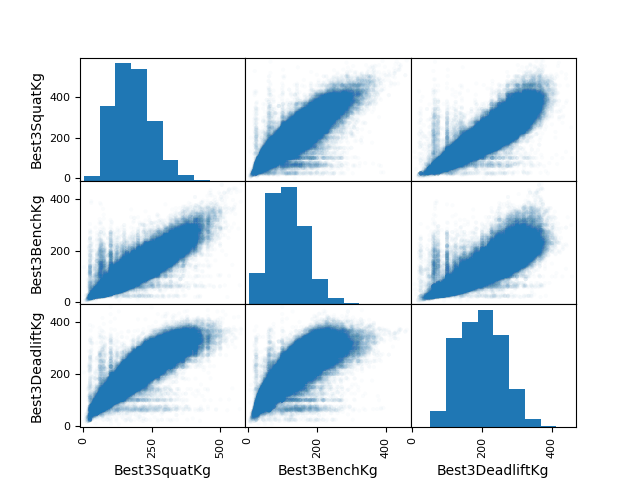

In [18]:
pd.plotting.scatter_matrix(df[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']], alpha=0.02)
plt.show()

The outliers can be detected and eliminated by an EllipticEnvelop.

In [19]:
cov = EllipticEnvelope(random_state=42, contamination=0.01).fit(df[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']])

In [42]:
maskOutliers = cov.predict(df[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']])
df_clean = df.copy()
print(df_clean.shape)
outliers = pd.Series(maskOutliers, index=df_clean.index)
df_clean = df_clean.loc[outliers==1,:]
print(df_clean.shape)

(760303, 40)
(752699, 40)


<IPython.core.display.Javascript object>


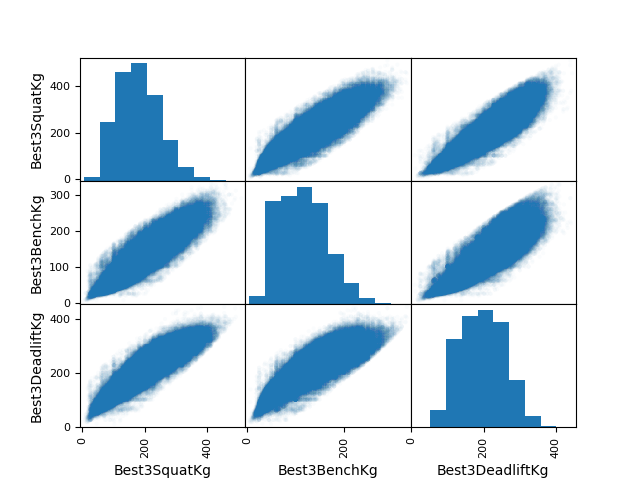

In [21]:
pd.plotting.scatter_matrix(df_clean[['Best3SquatKg', 'Best3BenchKg', 'Best3DeadliftKg']], alpha=0.02)
plt.show()

## Introduction of new features
The absolut values of how much weight a particular athlete can lift are highly correlated to aspects like personal talent, training background and other things which are outside of the scope of this dataset. That being said, I introduce three new features here, representing the athlete's performance in one exercise in relation to his/her total performance in all three exercises.

In [22]:
df_norm = df_clean.copy()
df_norm.loc[:,'Squat'] = df_norm.loc[:, 'Best3SquatKg']/df_norm.loc[:, 'TotalKg']*3
df_norm.loc[:, 'Bench'] = df_norm.loc[:, 'Best3BenchKg']/df_norm.loc[:, 'TotalKg']*3
df_norm.loc[:, 'Deadlift'] = df_norm.loc[:, 'Best3DeadliftKg']/df_norm.loc[:, 'TotalKg']*3
df_norm = df_norm[['Sex', 'Equipment', 'Age', 'BodyweightKg', 'Squat', 'Bench', 'Deadlift']]
df_norm.head()

,Sex,Equipment,Age,BodyweightKg,Squat,Bench,Deadlift
11,M,Wraps,27.5,82.5,1.003860,0.712080,1.284060
12,M,Wraps,32.5,82.5,1.079974,0.653334,1.266691
17,M,Wraps,24.0,110.0,1.123888,0.637155,1.238918
19,M,Wraps,38.5,110.0,1.090927,0.818195,1.090927
30,F,Wraps,27.0,75.0,1.196110,0.568617,1.235274


# Analysis and Visualization

In [28]:
print('Squat: mean {}, stdev {}'.format(df_norm['Squat'].mean(), df_norm['Squat'].std()))
print('Benchpress: mean {}, stdev {}'.format(df_norm['Bench'].mean(), df_norm['Bench'].std()))
print('Deadlift: mean {}, stdev {}'.format(df_norm['Deadlift'].mean(), df_norm['Deadlift'].std()))

Squat: mean 1.0987252742925373, stdev 0.09513960691893629
Benchpress: mean 0.6854467043719554, stdev 0.09552729214930632
Deadlift: mean 1.2158322651195657, stdev 0.11106679456903866


The data clearly shows that on average the highest weights are moved in the deadlift, while the lowest weights are moved in benchpress. More precisely deadlift performances average out at 122% of the total average, squat has an average of 110% and the average of benchpress is only 69%.

The Squat, Bench and Deadlift data can be interpreted as a 3D vector. However, since the length of the vector is not of interest in this case (it's always equal to 3), the actual information is two-dimensional. This circumstance can be exploited in order to create two-dimensional plots. For this purpose I reduce the 3D vectors $(S, B, D)$ to 2D data $x=(x_1, x_2)$ with $x_1 = S - \frac{1}{\sqrt{2}} B - \frac{1}{\sqrt{2}} D$ and $x_2 = \frac{1}{\sqrt{2}} B - \frac{1}{\sqrt{2}} D$, where $S$, $B$ and $D$ are the normalized squat, benchpress and deadlift performances.
In a second step I remove the mean of $x_1$ and $x_2$, such that a data point with $S=1.10$, $B=0.69$ and $D=1.22$ is represented by $x=(0,0)$ in the plots.

In [32]:
fac = math.sqrt(2)
# Reduce to two dimensions
df_norm.loc[:, 'x1'] = df_norm.loc[:,'Squat'] - df_norm.loc[:, 'Bench']/fac - df_norm.loc[:, 'Deadlift']/fac
df_norm.loc[:, 'x2'] = df_norm.loc[:, 'Bench']/fac - df_norm.loc[:, 'Deadlift']/fac
# Remove the mean
df_norm.loc[:, 'x1'] = df_norm.loc[:, 'x1'] - df_norm.loc[:, 'x1'].mean()
df_norm.loc[:, 'x2'] = df_norm.loc[:, 'x2'] - df_norm.loc[:, 'x2'].mean()

df_norm[['Squat', 'Bench', 'Deadlift', 'x1', 'x2']].head()

,Squat,Bench,Deadlift,x1,x2
11,1.003860,0.712080,1.284060,-0.161942,-0.029412
12,1.079974,0.653334,1.266691,-0.032007,-0.058670
17,1.123888,0.637155,1.238918,0.042986,-0.050472
19,1.090927,0.818195,1.090927,-0.013344,0.182189
30,1.196110,0.568617,1.235274,0.166248,-0.096359


The resulting 2D data can efficiently be represented in 2D histograms.

In [33]:
# Prepare 2D histogram function
bins = 20
plotrange = [[-.4, .4],[-.4, .4]]
cmap = plt.get_cmap('Blues')

def draw_arrows(ax):
    """ Draws arrows for three-dimensional coordinates """
    ax.arrow(0,0,0,0.3,head_width=0.025)
    ax.arrow(0,0,0.3/fac,-0.3/fac,head_width=0.025)
    ax.arrow(0,0,-0.3/fac,-0.3/fac,head_width=0.025)
    ax.text(0.05, 0.3, 'Squat')
    ax.text(0.25, -0.25, 'Bench')
    ax.text(-0.25, -0.25, 'Deadlift', horizontalalignment='right')

def plotSBDhist(ax, df, idx_mask, title):
    """Plots 2D histogram for Squat-Bench-Deadlift-Data filtered by idx_mask
    Args:
        - ax: matplotlib axis
        - df: Dataframe with columns 'x1' and 'x2'
        - idx_mask: True/False filtering array
        - title: Title printed above the plot
    Returns: nothing """
    ax.hist2d(df['x2'][idx_mask], df['x1'][idx_mask], bins=bins, range=plotrange, cmap=cmap)
    draw_arrows(ax)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])  

A comparison by gender shows that women are considerably better in squat and deadlift than in benchpress.

<IPython.core.display.Javascript object>


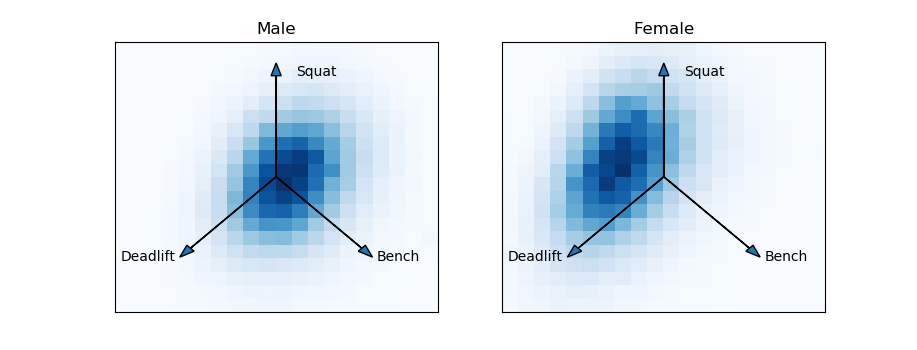

In [34]:
fig = plt.figure()
[ax1, ax2] = fig.subplots(nrows=1, ncols=2)

plotSBDhist(ax1, df_norm, df_norm['Sex'] == 'M', 'Male')
plotSBDhist(ax2, df_norm, df_norm['Sex'] == 'F', 'Female')

plt.show()

The data also shows that young people (under 20) are slightly better at squats, while the focus shifts to benchpress with older people.

<IPython.core.display.Javascript object>


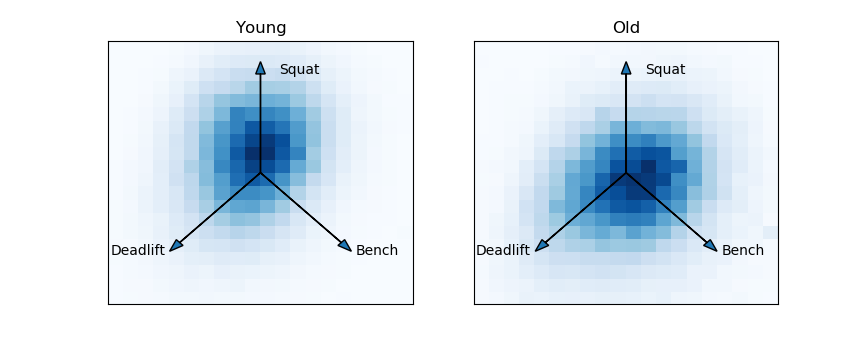

In [35]:
fig = plt.figure()
[ax1, ax2] = fig.subplots(nrows=1, ncols=2)

plotSBDhist(ax1, df_norm, df_norm['Age'] < 20, 'Young')
plotSBDhist(ax2, df_norm, df_norm['Age'] > 40, 'Old')

plt.show()

Another interesting fact is that increasing the bodyweight shifts the focus away from deadlift towards benchpress.

<IPython.core.display.Javascript object>


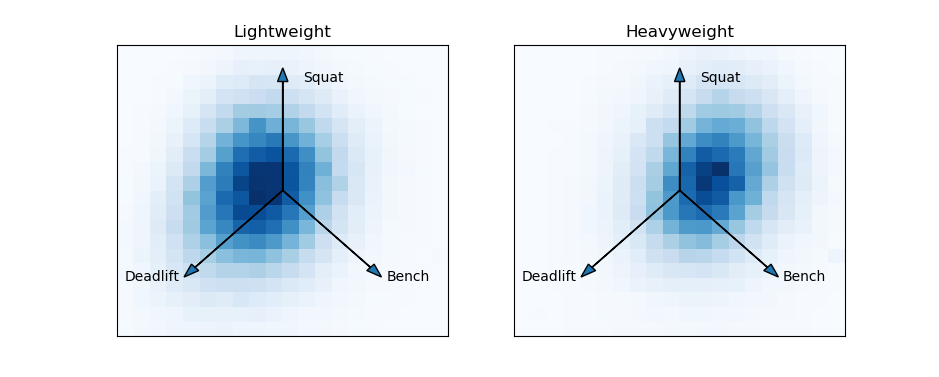

In [36]:
fig = plt.figure()
[ax1, ax2] = fig.subplots(nrows=1, ncols=2)

plotSBDhist(ax1, df_norm, df_norm['BodyweightKg'] < 80, 'Lightweight')
plotSBDhist(ax2, df_norm, df_norm['BodyweightKg'] > 100, 'Heavyweight')

plt.show()

# Training a regression model
In order to find an answer to the last question (which is age is the best for maximum strength?), I want to incorporate a linear regression model that predicts the sum of weight for squat, benchpress and deadlift based on gender, age and bodyweight of an athlete.
Different types of equipment are used in powerlifting meetings, which have an effect on the performance, so we also have to take the equipment into account here.

In [46]:
df_max = df_clean[['Sex', 'Age', 'BodyweightKg', 'Equipment', 'TotalKg']]
df_max.head()

,Sex,Age,BodyweightKg,Equipment,TotalKg
11,M,27.5,82.5,Wraps,582.87
12,M,32.5,82.5,Wraps,510.29
17,M,24.0,110.0,Wraps,768.84
19,M,38.5,110.0,Wraps,623.69
30,F,27.0,75.0,Wraps,347.00


The data is split up into train and test sets.

In [47]:
X = df_max.drop(columns='TotalKg')
y = df_max['TotalKg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In order to utilize the categorical columns 'Sex' and 'Equipment', I use a OneHotEncoder (similar to pandas get_dummies() function).

I expect the maximum strength point at an age between 25-35 and a relatively (but not extremely) high bodyweight. Since this cannot be represented by a strongly linear model I add powers of 2, 3 and 4 for the age and bodyweight values as new features. In addition, I use a standard scaler to scale the features.

For convenience the transformers are put together in a pipeline. This makes it easy to apply the same transformations to new data later on.

In [48]:
class PowersOfAgeAndBodyweight():
    """ Custom transformer adds powers of 2, 3, and 4 of age and bodyweight """
    def fit(self, X, y=None):
        """ This transformer doesn't need to be fit """
        return self
    def transform(self, X, y=None):
        """ Adds powers of 2, 3 and 4 of first and second column as new columns
        Args:
            X - Data as pandas dataframe or numpy array
            y - Target values (not used here)
        Returns: Extended data as numpy array
        """
        Xnew = np.array(X)
        age2 = Xnew[:,0]**2
        age3 = Xnew[:,0]**3
        age4 = Xnew[:,0]**4
        body2 = Xnew[:,1]**2
        body3 = Xnew[:,1]**3
        body4 = Xnew[:,1]**4
        return np.c_[Xnew, age2, age3, age4, body2, body3, body4]
    def fit_transform(self, X, y=None):
        """ Wrapper-function calling fit(X,y) and transform(X,y) """
        self.fit(X, y)
        result = self.transform(X, y)
        return result

# Pipeline for numerical columns
num_pipeline = Pipeline([
    ('addPowers', PowersOfAgeAndBodyweight()),
    ('std_scaler', StandardScaler())
])

num_cols = ['Age', 'BodyweightKg']
cat_cols = ['Sex', 'Equipment']

# Full pipeline (distinguishes between numerical and categorical columns)
full_pipeline = ColumnTransformer([
    ('num_pipe', num_pipeline, num_cols),
    ('cat_pipe', OneHotEncoder(), cat_cols)
])

In [49]:
full_pipeline.fit(X_train)

X_train_tr = full_pipeline.transform(X_train)
X_test_tr = full_pipeline.transform(X_test)

In [50]:
linreg = Ridge(alpha=0.01)
linreg.fit(X_train_tr, y_train)
print(linreg.score(X_train_tr, y_train))
print(linreg.score(X_test_tr, y_test))

0.7065562808539054
0.709646186830566


In [119]:
X_train.columns

Index(['Sex', 'Age', 'BodyweightKg', 'Equipment'], dtype='object')

In [142]:
age_sim = np.arange(16,76,1)
bodyweight_sim = np.ones(age_sim.shape)*80
sex_sim = np.full(age_sim.shape, 'M')
equipment_sim = np.full(age_sim.shape, 'Raw')

X_sim = pd.DataFrame({'Sex':sex_sim, 'Age': age_sim, 'BodyweightKg': bodyweight_sim, 'Equipment': equipment_sim})
X_sim_tr = full_pipeline.transform(X_sim)
y_sim = linreg.predict(X_sim_tr)

<IPython.core.display.Javascript object>


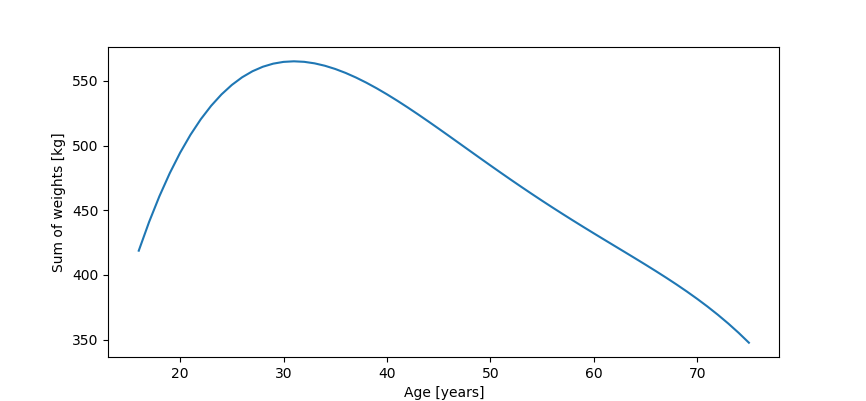

In [145]:
plt.plot(age_sim, y_sim)
plt.ylabel('Sum of weights [kg]')
plt.xlabel('Age [years]')
plt.show()

In [135]:
idx_max = np.argmax(y_sim)
age_sim[idx_max]

31